#Downloading and selecting Libraries


In [ ]:
!pip install photutils

In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

#Uploading FITs file

In [ ]:
# testfiler.info() # Display the top-level information in the fits file
# testfiler['PRIMARY'].header # Read the primary header information
testfiler=fits.open('Untitled2.FIT') #
image = testfiler['PRIMARY'].data

# Visualizing the FITS image

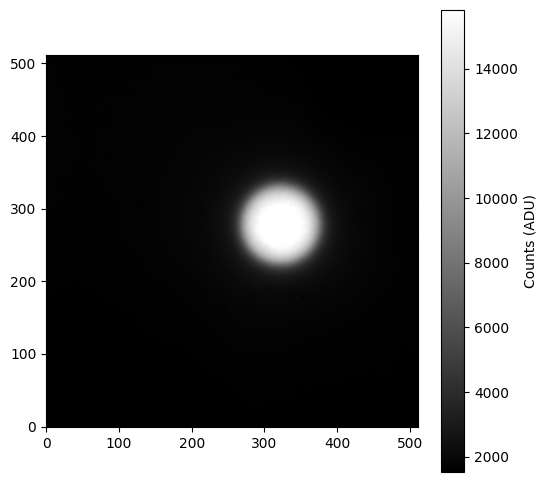

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(image, origin='lower', cmap='gray', vmin=np.percentile(image,5), vmax=np.percentile(image,99))
plt.colorbar(label='Counts (ADU)')
plt.show()

# Finding the star in the image
using Centroid: https://photutils.readthedocs.io/en/stable/user_guide/centroids.html

center x, y =  319 274


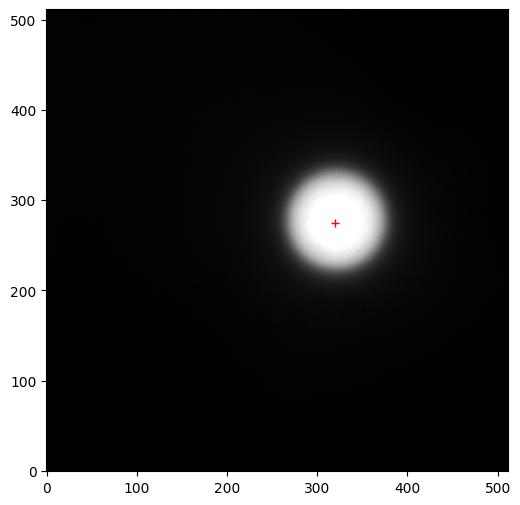

In [ ]:
# Finding star
x0, y0 = 310, 280
 # rough guess for central coordinates of a star
cutout = 51 # subimage or cutout around x0, y0.

from photutils.centroids import centroid_2dg, centroid_sources

# centroid_2g will fit 2d gausssian arund x0,y0 to find exact cenetr

x, y = centroid_sources(image, x0, y0, box_size=cutout, centroid_func=centroid_2dg)

print('center x, y = ',int(x.item()),int(y.item()))

plt.figure(figsize=(6,6))
plt.imshow(image, origin='lower', cmap='gray', vmin=np.percentile(image,5), vmax=np.percentile(image,99))
plt.plot(x,y, 'r+')
plt.show()

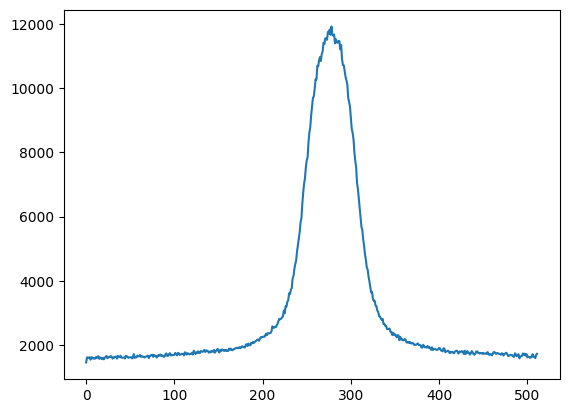

In [ ]:
plt.plot(image[:,int(y.item())])

fwhm_x =  103.818816879812
fwhm_y =  104.26420268827727
mean_FWHM =  104.04150978404464


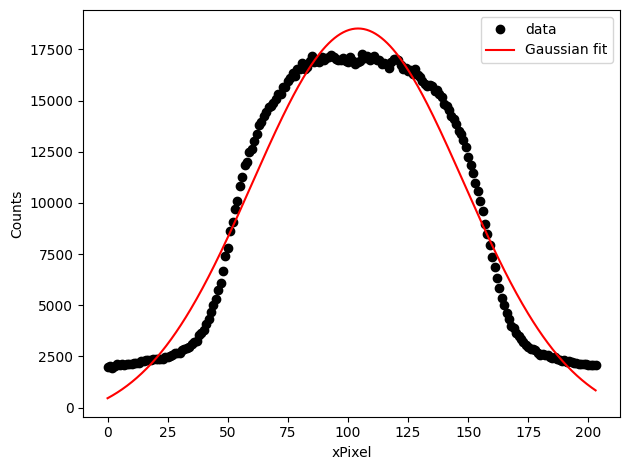

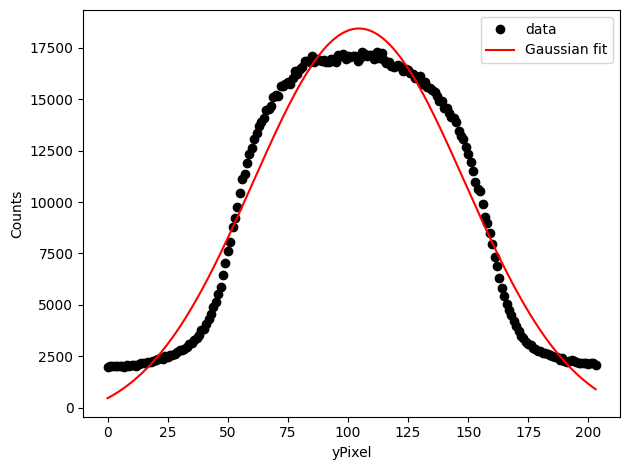

In [ ]:
extent = 2*cutout
imgcutout = image[int(y.item())-extent:int(y.item())+extent, int(x.item())-extent:int(x.item())+extent]
yc, xc = centroid_2dg(imgcutout)


x_slice = imgcutout[int(yc), :]
y_slice = imgcutout[:, int(xc)]

def gaussian_1d(x, amp, x0, sigma, offset):
    return offset + amp * np.exp(-(x-x0)**2 / (2*sigma**2))

from scipy.optimize import curve_fit

xvals = np.arange(len(x_slice))
yvals = np.arange(len(y_slice))
popt_x, _ = curve_fit(gaussian_1d, xvals, x_slice,
                      p0=[x_slice.max(), xc, 2, np.median(x_slice)])

popt_y, _ = curve_fit(gaussian_1d, yvals, y_slice,
                      p0=[y_slice.max(), xc, 2, np.median(y_slice)])

sigma_x = popt_x[2]
fwhm_x = 2.355 * sigma_x

sigma_y = popt_y[2]
fwhm_y = 2.355 * sigma_y

FWHM = 0.5 * (fwhm_x + fwhm_y)
print('fwhm_x = ',fwhm_x)
print('fwhm_y = ',fwhm_y)
print('mean_FWHM = ', FWHM )
# visualization

x_fine = np.linspace(xvals.min(), xvals.max(), 500)
plt.plot(xvals, x_slice, 'ko', label = 'data')
plt.plot(x_fine, gaussian_1d(x_fine, *popt_x), 'r-', label='Gaussian fit')
plt.xlabel('xPixel')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()
plt.show()
y_fine = np.linspace(yvals.min(), yvals.max(), 500)
plt.plot(yvals, y_slice, 'ko', label = 'data')
plt.plot(y_fine, gaussian_1d(y_fine, *popt_y), 'r-', label='Gaussian fit')
plt.xlabel('yPixel')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()
plt.show()



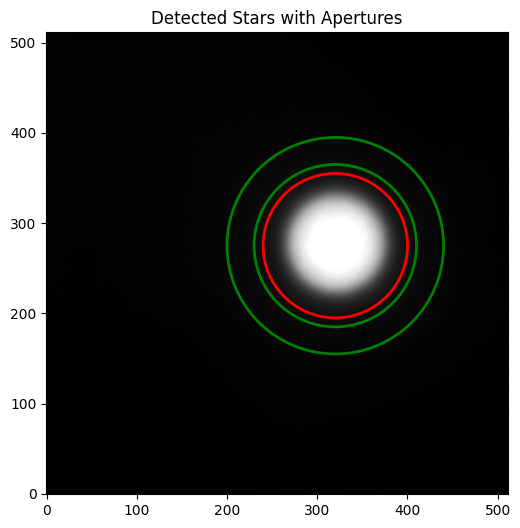

In [ ]:
# Selecting aperture and annulus aperture for photometry

positions = (int(np.round(x).item()), int(np.round(y).item()) )
apertures = CircularAperture(positions, r=80.) # $
annulus = CircularAnnulus(positions, r_in=90., r_out=120.) # background using annulus

plt.figure(figsize=(6,6))
plt.imshow(image, origin='lower', cmap='gray', vmin=np.percentile(image,5), vmax=np.percentile(image,99))
apertures.plot(color='red', lw=2)
annulus.plot(color='green', lw=2)
plt.title('Detected Stars with Apertures')
plt.show()

In [ ]:
# aperture photometry
phot_table = aperture_photometry(image, apertures) # counts in the aperture
print(phot_table)

# calculating median background
from photutils.aperture import ApertureStats
annulus_stats = ApertureStats(image, annulus)
bkg_median = annulus_stats.median
total_bkg = bkg_median * apertures.area
phot_table['bkg_total'] = total_bkg

# subtracting backgorund from aperture counts
phot_table['flux_bkgsub'] = phot_table['aperture_sum'] - total_bkg

print(phot_table)

 id xcenter ycenter    aperture_sum  
--- ------- ------- -----------------
  1   320.0   275.0 169820882.4077156
 id xcenter ycenter    aperture_sum       bkg_total        flux_bkgsub    
--- ------- ------- ----------------- ----------------- ------------------
  1   320.0   275.0 169820882.4077156 40152067.38700043 129668815.02071516


In [ ]:
# help(annulus_stats)
annulus_stats.mean, annulus_stats.median, np.median(image)

(np.float64(2051.083265925177), np.float64(2037.0), np.float64(1729.0))

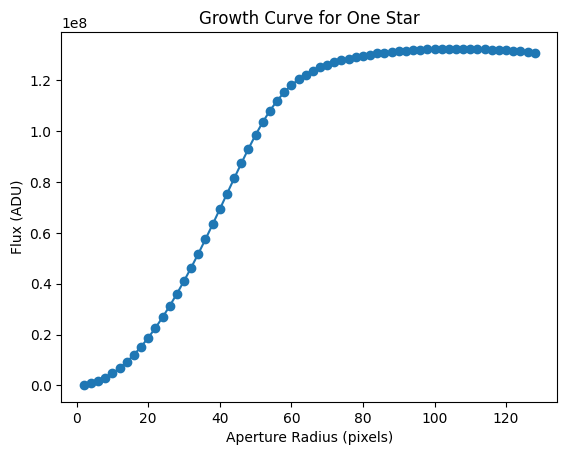

In [ ]:
radii = np.arange(2, 130, 2)
fluxes = []



phot_table['bkg'] = bkg_median
phot_table['bkg_total'] = bkg_median * apertures.area
phot_table['flux_bkgsub'] = phot_table['aperture_sum'] - phot_table['bkg_total']



for r in radii:
    ap = CircularAperture((int(np.round(x).item()), int(np.round(y).item())), r=r)
    bkg_aper = bkg_median * ap.area
    phot = aperture_photometry(image, ap)['aperture_sum'][0]
    f = phot - bkg_aper
    fluxes.append(f)


plt.plot(radii, fluxes, marker='o')
plt.xlabel('Aperture Radius (pixels)')
plt.ylabel('Flux (ADU)')
plt.title('Growth Curve for One Star')
plt.show()

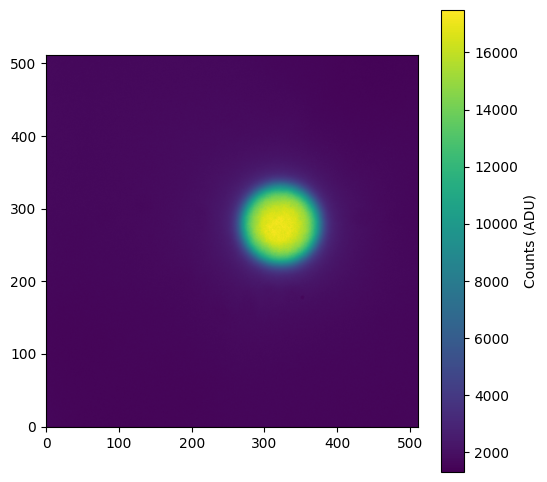

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(image, origin='lower')
plt.colorbar(label='Counts (ADU)')

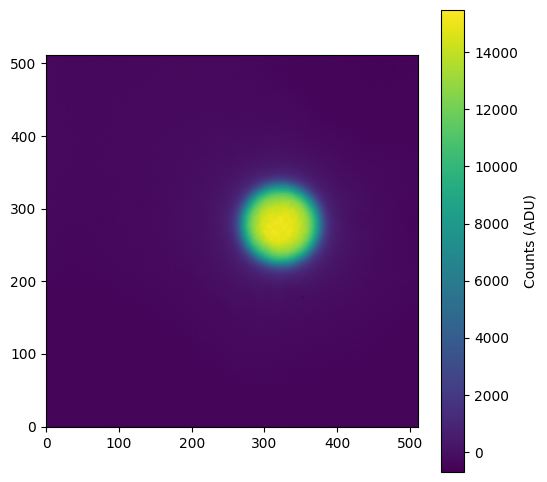

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(image-annulus_stats.mean, origin='lower')
plt.colorbar(label='Counts (ADU)')
plt.show()

#extract the image in .fits

In [ ]:
image_bkgsub = image - annulus_stats.mean
# primary_hdu = fits.PrimaryHDU(image_bkgsub)
# hdul = fits.HDUList([primary_hdu])
# hdul.writeto('after_bgk_sub.FIT', overwrite=True)
# print("Background-subtracted image created and saved as 'after_bgk_sub.FIT'.")

In [ ]:
from google.colab import files
# Save the background-subtracted image as 'final2.fits' in Colab
primary_hdu_final = fits.PrimaryHDU(image_bkgsub)
hdul_final = fits.HDUList([primary_hdu_final])
hdul_final.writeto('final2.fits', overwrite=True)
print("File 'final2.fits' created in Colab environment.")

# Provide the option to download the file to the local machine
files.download('final2.fits')


File 'final2.fits' created in Colab environment.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Comparing Original and Background-Subtracted Images

**Reasoning:**
To illustrate the difference between the original image and the background-subtracted image, I will display both images side-by-side using `matplotlib.pyplot.imshow`. I will also print statistical summaries (mean, median, standard deviation) for both images to quantify the effect of background subtraction.

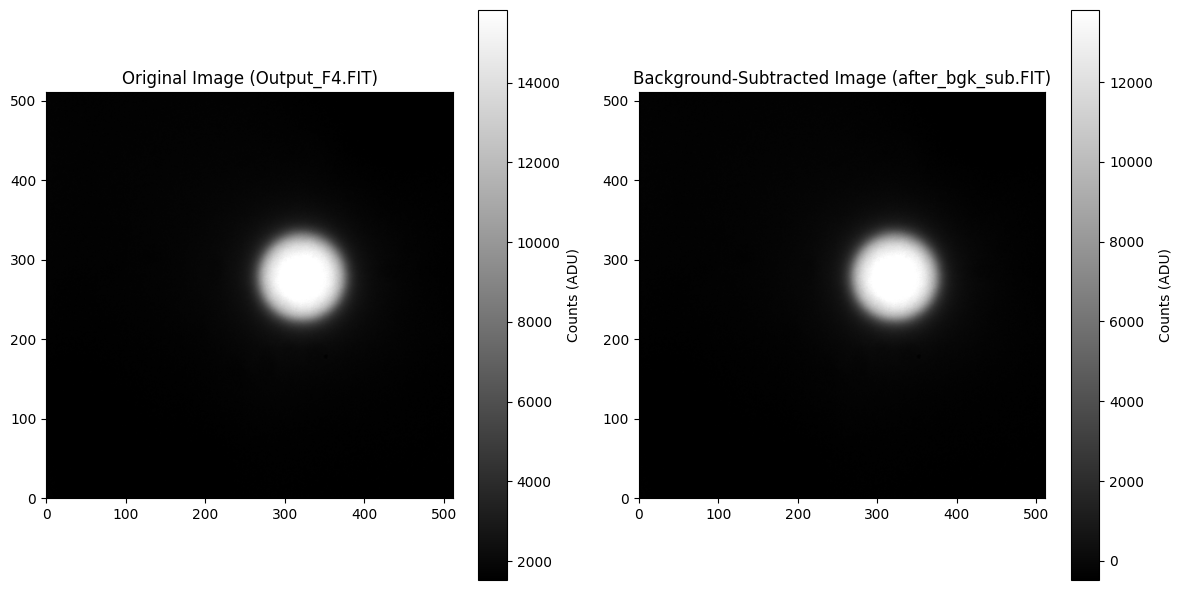


--- Statistical Comparison ---
Original Image (Output_F4.FIT):
  Mean: 2225.18
  Median: 1690.00
  Standard Deviation: 2329.15

Background-Subtracted Image (after_bgk_sub.FIT):
  Mean: 214.19
  Median: -320.99
  Standard Deviation: 2329.15


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, origin='lower', cmap='gray', vmin=np.percentile(image, 5), vmax=np.percentile(image, 99))
plt.colorbar(label='Counts (ADU)')
plt.title('Original Image (Output_F4.FIT)')

plt.subplot(1, 2, 2)
plt.imshow(image_bkgsub, origin='lower', cmap='gray', vmin=np.percentile(image_bkgsub, 5), vmax=np.percentile(image_bkgsub, 99))
plt.colorbar(label='Counts (ADU)')
plt.title('Background-Subtracted Image (after_bgk_sub.FIT)')

plt.tight_layout()
plt.show()

print("\n--- Statistical Comparison ---")
print("Original Image (Output_F4.FIT):")
print(f"  Mean: {np.mean(image):.2f}")
print(f"  Median: {np.median(image):.2f}")
print(f"  Standard Deviation: {np.std(image):.2f}")

print("\nBackground-Subtracted Image (after_bgk_sub.FIT):")
print(f"  Mean: {np.mean(image_bkgsub):.2f}")
print(f"  Median: {np.median(image_bkgsub):.2f}")
print(f"  Standard Deviation: {np.std(image_bkgsub):.2f}")
